<a href="https://colab.research.google.com/github/Sachini007/Data-Storm-3.0/blob/main/03-26/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [328]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split

In [329]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [330]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
import seaborn as sns

# load data

In [331]:
%cd /content/drive/MyDrive/Data-Storm-3.0/03-26

/content/drive/MyDrive/Data-Storm-3.0/03-26


In [401]:
file_name = './train_data.csv'
train_df = pd.read_csv(file_name,parse_dates=['DateID'] )
print(train_df.shape)
train_df.head()

(19921, 4)


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5


In [402]:
train_df = train_df.sort_values("DateID").reset_index(drop = True)

In [403]:
train_df.index.name = 'ID'

In [404]:
train_df.head()

,CategoryCode,ItemCode,DateID,DailySales
ID,,,,
0,category_2,174436,2021-10-01,9
1,category_2,118033,2021-10-01,4
2,category_2,20824,2021-10-01,7
3,category_1,1061341,2021-10-01,11
4,category_1,76399,2021-10-01,14


In [405]:
train_df.dtypes

CategoryCode            object
ItemCode                 int64
DateID          datetime64[ns]
DailySales               int64
dtype: object

In [409]:
validation_df = pd.read_csv('./new_validation_data.csv',parse_dates=['DateID'])
# validation_df.drop('Week', axis=1, inplace=True)
print(validation_df.shape)
validation_df = validation_df.sort_values("DateID").reset_index(drop = True)
validation_df.head()

(2590, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_2,1044502,w1,2022-02-14
1,category_2,172582,w1,2022-02-14
2,category_3,1066570,w1,2022-02-14
3,category_2,1090240,w1,2022-02-14
4,category_3,1097143,w1,2022-02-14


In [410]:
validation_df.index.name = 'ID'

In [411]:
validation_df_original = validation_df.copy()

In [412]:
test_df = pd.read_csv('./new_test_data.csv',parse_dates=['DateID'])
# test_df.drop('Week', axis=1, inplace=True)
print(test_df.shape)
test_df = test_df.sort_values("DateID").reset_index(drop = True)
test_df.head()

(2639, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_1,370195,w1,2022-02-14
1,category_1,1032559,w1,2022-02-14
2,category_2,174436,w1,2022-02-14
3,category_2,262384,w1,2022-02-14
4,category_1,371104,w1,2022-02-14


In [413]:
test_df.index.name = 'ID'

In [414]:
test_df_original = test_df.copy()

# Daily Sales distribution

In [339]:
train_df['DailySales_bins'] = pd.cut(train_df.DailySales,[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,150,200,250,300,350,400,450])
print('Max sale:', train_df.DailySales.max())
print('Min sale:', train_df.DailySales.min())
print('Avg sale:', train_df.DailySales.mean())
print('Total sale:', train_df.DailySales.sum())

Max sale: 434
Min sale: 1
Avg sale: 7.351889965363185
Total sale: 146457


In [340]:
pd.value_counts(train_df.DailySales_bins)

(0, 1]        4413
(1, 2]        3503
(2, 3]        2376
(3, 4]        1887
(10, 20]      1868
(4, 5]        1297
(5, 6]        1026
(6, 7]         770
(7, 8]         583
(20, 30]       551
(8, 9]         480
(9, 10]        428
(50, 100]      304
(30, 40]       202
(40, 50]       128
(100, 150]      83
(150, 200]      15
(200, 250]       4
(250, 300]       1
(300, 350]       1
(400, 450]       1
(350, 400]       0
Name: DailySales_bins, dtype: int64

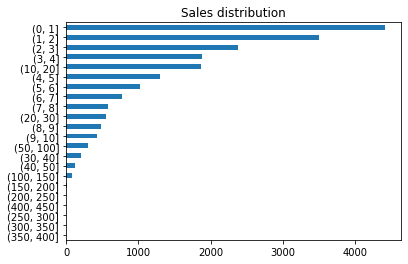

In [341]:
sales_count = pd.value_counts(train_df.DailySales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', )

In [342]:
total_points = pd.value_counts(train_df.DailySales_bins).sum()
pd.value_counts(train_df.DailySales_bins).apply(lambda s: (s/total_points)*100)

(0, 1]        22.152502
(1, 2]        17.584459
(2, 3]        11.927112
(3, 4]         9.472416
(10, 20]       9.377039
(4, 5]         6.510717
(5, 6]         5.150344
(6, 7]         3.865268
(7, 8]         2.926560
(20, 30]       2.765925
(8, 9]         2.409518
(9, 10]        2.148487
(50, 100]      1.526028
(30, 40]       1.014005
(40, 50]       0.642538
(100, 150]     0.416646
(150, 200]     0.075297
(200, 250]     0.020079
(250, 300]     0.005020
(300, 350]     0.005020
(400, 450]     0.005020
(350, 400]     0.000000
Name: DailySales_bins, dtype: float64

# Sales variation across category

In [343]:
sales_pivoted_df = pd.pivot_table(train_df, index='CategoryCode', values=['DailySales','DateID'], columns='ItemCode', aggfunc=np.mean)
sales_pivoted_df

DailySales                                                    \
ItemCode        3418      3427      7666      9925      16936     17287     
CategoryCode                                                                
category_1     9.829457  6.538462       NaN       NaN       NaN  4.293478   
category_2          NaN       NaN       NaN  2.479167       NaN       NaN   
category_3          NaN       NaN  14.80531       NaN  8.135135       NaN   
category_4          NaN       NaN       NaN       NaN       NaN       NaN   

                                                         ...            \
ItemCode        17296      20824      23200     23569    ...   1098502   
CategoryCode                                             ...             
category_1    71.191176        NaN        NaN       NaN  ...       NaN   
category_2          NaN  18.647059        NaN  3.530973  ...  1.594937   
category_3          NaN        NaN        NaN       NaN  ...       NaN   
category_4          NaN        NaN  13.860759       NaN  ...       NaN   

                                                                        \
ItemCode       1101553   1101562 1101571   1101661   1101769   1103056   
CategoryCode                                                             
category_1         NaN       NaN     NaN       NaN       NaN       NaN   
category_2    1.906667  2.265957     4.8       NaN  2.921053  2.826923   
category_3         NaN       NaN     NaN  6.205607       NaN       NaN   
category_4         NaN       NaN     NaN       NaN       NaN       NaN   

                                            
ItemCode       1105009   1105018   1105027  
CategoryCode                                
category_1         NaN       NaN       NaN  
category_2    1.898551  1.863636  1.961538  
category_3         NaN       NaN       NaN  
category_4         NaN       NaN       NaN  

[4 rows x 194 columns]

In [344]:
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['AvgDailySale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)
sales_across_store_df['AvgDailySale']

CategoryCode
category_1     6.280729
category_2     4.139096
category_3    10.856383
category_4    15.820818
Name: AvgDailySale, dtype: float64

In [345]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.AvgDailySale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.AvgDailySale.values,
        color = sales_across_store_df.AvgDailySale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg Daily sales per Category',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Category',
        ticklen= 4,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Daily Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

# Sales variation across item

In [ ]:
sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['ItemID', 'AvgDailySale'])
    # And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='AvgDailySale', ascending=False, inplace=True)
    # Display the top 10 rows
avg_sales_per_item_across_stores_df.head(10)

,ItemID,AvgDailySale
60,61,89.355556
49,50,71.310606
6,7,71.191176
157,158,34.094118
48,49,22.742647
90,91,22.442478
54,55,22.213235
18,19,20.066667
7,8,18.647059
121,122,18.029851


In [ ]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.AvgDailySale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 200)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.ItemID.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 200,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

# time series visualization of sales

In [ ]:
# store_item_df = train_df.copy()
# # First, let us filterout the required data
# item_id = 117610   # Some item
# print('Before filter:', store_item_df.shape)
# store_item_df = store_item_df[store_item_df.ItemCode == item_id]
# print('After filter:', store_item_df.shape)
# store_item_df.head()

# store_item_ts_data = [go.Scatter(
#         x=store_item_df.DateID,
#         y=store_item_df.DailySales)]
# py.iplot(store_item_ts_data)
    

Feature Engineering

In [415]:
def date_features(df):
    # Date Features
    # df['date'] = pd.to_datetime(df['DateID'])
    df['year'] = df.DateID.dt.year
    df['month'] = df.DateID.dt.month
    df['day'] = df.DateID.dt.day
    df['dayofyear'] = df.DateID.dt.dayofyear
    df['dayofweek'] = df.DateID.dt.dayofweek
    df['weekofyear'] = df.DateID.dt.weekofyear
    
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
    # Drop date
    df.drop('DateID', axis=1, inplace=True)
    
    return df

In [417]:
train_df, validation_df, test_df = date_features(train_df), date_features(validation_df), date_features(test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [418]:
validation_df = validation_df.drop('Week', axis=1)
test_df = test_df.drop('Week', axis=1)

In [419]:
train_df.head()

,CategoryCode,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year
ID,,,,,,,,,,
0,category_2,174436,9,2021,10,1,274,4,39,36.240896
1,category_2,118033,4,2021,10,1,274,4,39,36.240896
2,category_2,20824,7,2021,10,1,274,4,39,36.240896
3,category_1,1061341,11,2021,10,1,274,4,39,36.240896
4,category_1,76399,14,2021,10,1,274,4,39,36.240896


In [420]:
validation_df.head()

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year
ID,,,,,,,,,
0,category_2,1044502,2022,2,14,45,0,7,29.53522
1,category_2,172582,2022,2,14,45,0,7,29.53522
2,category_3,1066570,2022,2,14,45,0,7,29.53522
3,category_2,1090240,2022,2,14,45,0,7,29.53522
4,category_3,1097143,2022,2,14,45,0,7,29.53522


In [421]:
test_df.head()

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year
ID,,,,,,,,,
0,category_1,370195,2022,2,14,45,0,7,29.53522
1,category_1,1032559,2022,2,14,45,0,7,29.53522
2,category_2,174436,2022,2,14,45,0,7,29.53522
3,category_2,262384,2022,2,14,45,0,7,29.53522
4,category_1,371104,2022,2,14,45,0,7,29.53522


In [422]:
train_df['daily_avg']  = train_df.groupby(['ItemCode','CategoryCode','dayofweek'])['DailySales'].transform('mean')
train_df['monthly_avg'] = train_df.groupby(['ItemCode','CategoryCode','month'])['DailySales'].transform('mean')
train_df = train_df.dropna()

# Average sales for Day_of_week = d per Item,Store
daymonth_avg = train_df.groupby(['ItemCode','CategoryCode','dayofweek'])['DailySales'].mean().reset_index()
# Average sales for Month = m per Item,Store
monthly_avg = train_df.groupby(['ItemCode','CategoryCode','month'])['DailySales'].mean().reset_index()

In [423]:
train_df.head()

,CategoryCode,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg
ID,,,,,,,,,,,,
0,category_2,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774
1,category_2,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391
2,category_2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065
3,category_1,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692
4,category_1,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545


In [424]:
# Merge Test with Daily Avg, Monthly Avg
def merge(df1, df2, col,col_name):
    
    df1 = pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col,
            left_index=False, right_index=False, sort=True,
             copy=True, indicator=False)
    
    df1 = df1.rename(columns={'DailySales':col_name})
    return df1

In [355]:
train_df.head()

,CategoryCode,ItemCode,DailySales,DailySales_bins,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg
ID,,,,,,,,,,,,,
0,category_2,174436,9,"(8, 9]",2021,10,1,274,4,39,36.240896,7.250000,10.096774
1,category_2,118033,4,"(3, 4]",2021,10,1,274,4,39,36.240896,4.000000,2.217391
2,category_2,20824,7,"(6, 7]",2021,10,1,274,4,39,36.240896,19.000000,17.258065
3,category_1,1061341,11,"(10, 20]",2021,10,1,274,4,39,36.240896,7.875000,7.807692
4,category_1,76399,14,"(10, 20]",2021,10,1,274,4,39,36.240896,7.133333,4.454545


In [356]:
daymonth_avg.head()

,ItemCode,CategoryCode,dayofweek,DailySales
0,3418,category_1,0,10.263158
1,3418,category_1,1,9.611111
2,3418,category_1,2,8.894737
3,3418,category_1,3,14.055556
4,3418,category_1,4,9.950000


In [357]:
monthly_avg.head()

,ItemCode,CategoryCode,month,DailySales
0,3418,category_1,1,12.100000
1,3418,category_1,2,12.230769
2,3418,category_1,10,6.793103
3,3418,category_1,11,7.846154
4,3418,category_1,12,11.129032


In [358]:
validation_df.head()

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year
ID,,,,,,,,,
0,category_2,1044502,2022,2,14,45,0,7,29.53522
1,category_2,172582,2022,2,14,45,0,7,29.53522
2,category_3,1066570,2022,2,14,45,0,7,29.53522
3,category_2,1090240,2022,2,14,45,0,7,29.53522
4,category_3,1097143,2022,2,14,45,0,7,29.53522


In [425]:
# Add Daily_avg and Monthly_avg features to test 
validation_df = merge(validation_df, daymonth_avg, ['ItemCode','CategoryCode','dayofweek'],'daily_avg')
validation_df = merge(validation_df, monthly_avg,['ItemCode','CategoryCode','month'],'monthly_avg')

# Add Daily_avg and Monthly_avg features to test 
test_df = merge(test_df, daymonth_avg, ['ItemCode','CategoryCode','dayofweek'],'daily_avg')
test_df = merge(test_df, monthly_avg,['ItemCode','CategoryCode','month'],'monthly_avg')

# Sales Rolling mean sequence per item 
rolling_10 = train_df.groupby(['ItemCode'])['DailySales'].rolling(5).mean().reset_index()
train_df['rolling_mean'] = rolling_10['DailySales'] 

# 90 last days of training rolling mean sequence added to test data
rolling_last90 = train_df.groupby(['ItemCode','CategoryCode'])['rolling_mean'].tail(90).copy()
validation_df['rolling_mean'] = rolling_last90.reset_index().drop('ID', axis=1)
test_df['rolling_mean'] = rolling_last90.reset_index().drop('ID', axis=1)

# Shifting rolling mean 3 months
train_df['rolling_mean'] = train_df.groupby(['ItemCode'])['rolling_mean'].shift(90) # Create a feature with rolling mean of day - 90
train_df.head()

,CategoryCode,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean
ID,,,,,,,,,,,,,
0,category_2,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774,NaN
1,category_2,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391,NaN
2,category_2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065,NaN
3,category_1,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692,NaN
4,category_1,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545,NaN


In [426]:
train_df['rolling_mean'] = train_df['rolling_mean'].fillna(0)
validation_df['rolling_mean'] = validation_df['rolling_mean'].fillna(0)
test_df['rolling_mean'] = test_df['rolling_mean'].fillna(0)

In [474]:
train_df['monthly_avg'] = train_df['monthly_avg'].fillna(0)
validation_df['monthly_avg'] = validation_df['monthly_avg'].fillna(0)
test_df['monthly_avg'] = test_df['monthly_avg'].fillna(0)

In [427]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoded_train = pd.DataFrame(enc.fit_transform(train_df['CategoryCode'].values.reshape(-1,1)))
encoded_val = pd.DataFrame(enc.transform(validation_df['CategoryCode'].values.reshape(-1,1)))
encoded_test = pd.DataFrame(enc.transform(test_df['CategoryCode'].values.reshape(-1,1)))

In [428]:
train_df['Category_1'] = encoded_train[0]
train_df['Category_2'] = encoded_train[1]
train_df['Category_3'] = encoded_train[2]

In [429]:
validation_df['Category_1'] = encoded_val[0]
validation_df['Category_2'] = encoded_val[1]
validation_df['Category_3'] = encoded_val[2]

In [430]:
test_df['Category_1'] = encoded_test[0]
test_df['Category_2'] = encoded_test[1]
test_df['Category_3'] = encoded_test[2]

In [431]:
train_df.head()

,CategoryCode,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
ID,,,,,,,,,,,,,,,,
0,category_2,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774,0.0,1.0,0.0,0.0
1,category_2,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391,0.0,1.0,0.0,0.0
2,category_2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065,0.0,1.0,0.0,0.0
3,category_1,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692,0.0,0.0,0.0,0.0
4,category_1,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545,0.0,0.0,0.0,0.0


In [447]:
# train_df = train_df.drop('CategoryCode', axis=1)
# train_df = train_df.drop('DailySales_bins', axis=1)
test_df = test_df.drop('CategoryCode', axis=1)
validation_df = validation_df.drop('CategoryCode', axis=1)

In [433]:
train_df.head()

,CategoryCode,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
ID,,,,,,,,,,,,,,,,
0,category_2,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774,0.0,1.0,0.0,0.0
1,category_2,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391,0.0,1.0,0.0,0.0
2,category_2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065,0.0,1.0,0.0,0.0
3,category_1,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692,0.0,0.0,0.0,0.0
4,category_1,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545,0.0,0.0,0.0,0.0


In [435]:
test_df.head()

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
0,category_2,9925,2022,2,14,45,0,7,29.535220,2.714286,2.636364,4.8,1.0,0.0,0.0
1,category_2,9925,2022,2,21,52,0,8,30.334472,2.714286,2.636364,7.6,1.0,0.0,0.0
2,category_2,9925,2022,2,28,59,0,9,31.011346,2.714286,2.636364,9.0,1.0,0.0,0.0
3,category_2,9925,2022,2,15,46,1,7,29.658453,3.133333,2.636364,4.6,1.0,0.0,0.0
4,category_2,9925,2022,2,22,53,1,8,30.437805,3.133333,2.636364,6.2,1.0,0.0,0.0


In [ ]:
# cols = ['ItemCode','month','year','day','dayofyear','dayofweek','DailySales','weekofyear']
sns.heatmap(train_df.drop('ID'))

In [436]:
validation_df.head()

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
0,category_1,3418,2022,2,14,45,0,7,29.535220,10.263158,12.230769,4.8,0.0,0.0,0.0
1,category_1,3418,2022,2,21,52,0,8,30.334472,10.263158,12.230769,7.6,0.0,0.0,0.0
2,category_1,3418,2022,2,28,59,0,9,31.011346,10.263158,12.230769,9.0,0.0,0.0,0.0
3,category_1,3418,2022,2,15,46,1,7,29.658453,9.611111,12.230769,4.6,0.0,0.0,0.0
4,category_1,3418,2022,2,22,53,1,8,30.437805,9.611111,12.230769,6.2,0.0,0.0,0.0


In [379]:
train_df.head(10)

,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
ID,,,,,,,,,,,,,,,
0,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774,0.0,1.0,0.0,0.0
1,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391,0.0,1.0,0.0,0.0
2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065,0.0,1.0,0.0,0.0
3,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692,0.0,0.0,0.0,0.0
4,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545,0.0,0.0,0.0,0.0
5,1032541,119,2021,10,1,274,4,39,36.240896,18.650000,11.419355,0.0,0.0,0.0,0.0
6,1076920,3,2021,10,1,274,4,39,36.240896,3.000000,2.619048,0.0,1.0,0.0,0.0
7,1090240,2,2021,10,1,274,4,39,36.240896,6.235294,3.555556,0.0,1.0,0.0,0.0
8,1054978,2,2021,10,1,274,4,39,36.240896,6.055556,8.666667,0.0,0.0,0.0,0.0


In [446]:
validation_df

,CategoryCode,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
0,category_1,3418,2022,2,14,45,0,7,29.535220,10.263158,12.230769,4.8,0.0,0.0,0.0
1,category_1,3418,2022,2,21,52,0,8,30.334472,10.263158,12.230769,7.6,0.0,0.0,0.0
2,category_1,3418,2022,2,28,59,0,9,31.011346,10.263158,12.230769,9.0,0.0,0.0,0.0
3,category_1,3418,2022,2,15,46,1,7,29.658453,9.611111,12.230769,4.6,0.0,0.0,0.0
4,category_1,3418,2022,2,22,53,1,8,30.437805,9.611111,12.230769,6.2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,category_2,1105009,2022,3,11,70,4,10,31.897757,2.307692,NaN,5.4,1.0,0.0,0.0
2586,category_2,1105009,2022,3,5,64,5,9,31.437287,2.200000,NaN,4.8,1.0,0.0,0.0
2587,category_2,1105009,2022,3,12,71,5,10,31.969823,2.200000,NaN,5.4,1.0,0.0,0.0
2588,category_2,1105009,2022,3,6,65,6,9,31.517603,1.750000,NaN,7.4,1.0,0.0,0.0


# LIGHTGBM

In [448]:
# train_df['DateID'] = pd.to_datetime(train_df['DateID'])
# #validation_df['date'] = pd.to_datetime(train_df['date'])

# train_df['month'] = train_df['DateID'].dt.month
# train_df['day'] = train_df['DateID'].dt.dayofweek
# train_df['year'] = train_df['DateID'].dt.year


# # validation_df['month'] = validation_df['date'].dt.month
# # validation_df['day'] = validation_df['date'].dt.dayofweek
# # validation_df['year'] = validation_df['date'].dt.year
# validation_df = validation_df.drop('CategoryCode',axis=1)
col = [i for i in train_df.columns if i not in ['DailySales']]
y = 'DailySales'
train_x, train_y = train_df[col], train_df[y]
val_x = validation_df[col]
test_x = test_df[col]

In [449]:
train_x.shape, val_x.shape, test_x.shape

((19921, 14), (2590, 14), (2639, 14))

In [450]:
train_x.head()

,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
ID,,,,,,,,,,,,,,
0,174436,2021,10,1,274,4,39,36.240896,7.250000,10.096774,0.0,1.0,0.0,0.0
1,118033,2021,10,1,274,4,39,36.240896,4.000000,2.217391,0.0,1.0,0.0,0.0
2,20824,2021,10,1,274,4,39,36.240896,19.000000,17.258065,0.0,1.0,0.0,0.0
3,1061341,2021,10,1,274,4,39,36.240896,7.875000,7.807692,0.0,0.0,0.0,0.0
4,76399,2021,10,1,274,4,39,36.240896,7.133333,4.454545,0.0,0.0,0.0,0.0


In [ ]:
#reshape
train_x = np.array(train_x).reshape(train_x.shape[0], 1, train_x.shape[1])
val_x = np.array(val_x).reshape(val_x.shape[0], 1, val_x.shape[1])
train_x.shape,val_x.shape

((15936, 1, 4), (3985, 1, 4))

In [ ]:
train_x

array([[[ 877624,      10,       3,    2021]],

       [[1030948,      11,       2,    2021]],

       [[1047967,       1,       0,    2022]],

       ...,

       [[ 124774,      11,       1,    2021]],

       [[  17287,       2,       2,    2022]],

       [[ 216151,      11,       1,    2021]]])

In [ ]:
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')

In [ ]:
_optimiser = ['Adam','Nadam','RMSprop']
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 4), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[0])
model.summary()
model.fit(train_x,train_y, batch_size=32,epochs=25)
#submission = pd.read_csv("../input/demand-forecasting-kernels-only/sample_submission.csv")
#submission['sales'] = model.predict(test_x)
#submission.to_csv("submission_Adam")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (32, 144)                 85824     
                                                                 
 dense_2 (Dense)             (32, 1)                   145       
                                                                 
Total params: 85,969
Trainable params: 85,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
498/498 [==============================] - 5s 5ms/step - loss: 209.3234
Epoch 2/25
498/498 [==============================] - 2s 4ms/step - loss: 201.4798
Epoch 3/25
498/498 [==============================] - 2s 4ms/step - loss: 201.4818
Epoch 4/25
498/498 [==============================] - 2s 4ms/step - loss: 201.4739
Epoch 5/25
498/498 [==============================] - 2s 4ms/step - loss: 201.4925
Epoch 6/25
498/498 [===========

In [ ]:
x = model.predict(test_x[:3968])

In [ ]:
train_x = np.squeeze(train_x, axis=1)
test_x = np.squeeze(test_x, axis = 1)

In [ ]:
# validation_df['DateID'] = pd.to_datetime(validation_df['DateID'])

# validation_df['month'] = validation_df['DateID'].dt.month
# validation_df['day'] = validation_df['DateID'].dt.dayofweek
# validation_df['year'] = validation_df['DateID'].dt.year



# col = [i for i in train_df.columns if i not in ['DateID','CategoryCode','DailySales_bins']]
# y = 'DailySales'
# train_x, test_x, train_y, test_y = train_test_split(train_df[col],train_df[y], test_size=0.2, random_state=2018)

(15936, 5)

In [451]:
%%time

def model(train_x,train_y,val_x):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    # lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, verbose_eval=50)
    y_test = model.predict(val_x)
    return y_test,model

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


Validation Predictions

In [ ]:
# new_val_df = pd.read_csv('/content/new_validation_data.csv')
# print(new_val_df.shape)
# new_val_df.head()

(2590, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_2,1044502,w1,2022-02-14
1,category_2,1044502,w1,2022-02-15
2,category_2,1044502,w1,2022-02-16
3,category_2,1044502,w1,2022-02-17
4,category_2,1044502,w1,2022-02-18


In [ ]:
# new_val_df['DateID'] = pd.to_datetime(new_val_df['DateID'])
# #validation_df['date'] = pd.to_datetime(train_df['date'])

# new_val_df['month'] = new_val_df['DateID'].dt.month
# new_val_df['day'] = new_val_df['DateID'].dt.dayofweek
# new_val_df['year'] = new_val_df['DateID'].dt.year


In [ ]:
# col = [i for i in new_val_df.columns if i not in ['DateID','CategoryCode','DailySales_bins', 'Week']]
# y = 'DailySales'
# val_x = new_val_df[col]

In [452]:
ypred, model = model(train_x,train_y,val_x)

In [396]:
ypred

array([5.92993517, 8.54113238, 6.53257372, ..., 0.91698168, 2.54695472,
       0.91630614])

In [453]:
validation_df_original['predictions'] = ypred
validation_df_original.head()

,CategoryCode,ItemCode,Week,year,month,day,dayofyear,dayofweek,weekofyear,day^year,predictions
ID,,,,,,,,,,,
0,category_2,1044502,w1,2022,2,14,45,0,7,29.53522,5.929935
1,category_2,172582,w1,2022,2,14,45,0,7,29.53522,8.541132
2,category_3,1066570,w1,2022,2,14,45,0,7,29.53522,6.532574
3,category_2,1090240,w1,2022,2,14,45,0,7,29.53522,4.429626
4,category_3,1097143,w1,2022,2,14,45,0,7,29.53522,5.435323


In [457]:
validation_df_original.to_csv('Validation_with_preds.csv')

Test Predictions

In [ ]:
# new_test_df = pd.read_csv('/content/new_test_data.csv')
# print(new_test_df.shape)
# new_test_df.head()

(2639, 4)


,CategoryCode,ItemCode,Week,DateID
0,category_1,43738,w4,2022-03-07
1,category_1,43738,w4,2022-03-08
2,category_1,43738,w4,2022-03-09
3,category_1,43738,w4,2022-03-10
4,category_1,43738,w4,2022-03-11


In [ ]:
# new_test_df['DateID'] = pd.to_datetime(new_test_df['DateID'])
# #validation_df['date'] = pd.to_datetime(train_df['date'])

# new_test_df['month'] = new_test_df['DateID'].dt.month
# new_test_df['day'] = new_test_df['DateID'].dt.dayofweek
# new_test_df['year'] = new_test_df['DateID'].dt.year


In [ ]:
# col = [i for i in new_test_df.columns if i not in ['DateID','CategoryCode','DailySales_bins', 'Week']]
# y = 'DailySales'
# eval_x = new_test_df[col]

In [455]:
test_preds = model.predict(test_x)

In [458]:
test_df_original['predictions'] = test_preds
test_df_original.head()

,CategoryCode,ItemCode,Week,DateID,predictions
ID,,,,,
0,category_1,370195,w1,2022-02-14,1.732964
1,category_1,1032559,w1,2022-02-14,3.193396
2,category_2,174436,w1,2022-02-14,2.365438
3,category_2,262384,w1,2022-02-14,0.845794
4,category_1,371104,w1,2022-02-14,1.398962


In [459]:
test_df_original.to_csv('test_with_preds.csv')

MAPE

In [467]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE calculation

In [472]:
weekly_data = pd.read_csv('./Validation_with_preds_weekly.csv')
validation_data = pd.read_csv('./validation_data.csv')
validation_data.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [470]:
weekly_data.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,23.0
1,category_2,1105009,w1,29.0
2,category_2,913561,w4,10.0
3,category_1,1048975,w4,13.0
4,category_1,17287,w2,17.0


In [473]:
mean_absolute_percentage_error(validation_data['WeeklySales'],weekly_data['WeeklySales'])

159.2719018965245

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(validation_data['WeeklySales'],weekly_data['WeeklySales'])

0.7966534815905127

In [460]:
train_df

,ItemCode,DailySales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
ID,,,,,,,,,,,,,,,
0,174436,9,2021,10,1,274,4,39,36.240896,7.250000,10.096774,0.0,1.0,0.0,0.0
1,118033,4,2021,10,1,274,4,39,36.240896,4.000000,2.217391,0.0,1.0,0.0,0.0
2,20824,7,2021,10,1,274,4,39,36.240896,19.000000,17.258065,0.0,1.0,0.0,0.0
3,1061341,11,2021,10,1,274,4,39,36.240896,7.875000,7.807692,0.0,0.0,0.0,0.0
4,76399,14,2021,10,1,274,4,39,36.240896,7.133333,4.454545,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19916,57058,3,2022,2,13,44,6,6,29.408562,2.100000,1.777778,0.0,1.0,0.0,0.0
19917,1084498,4,2022,2,13,44,6,6,29.408562,5.562500,5.000000,18.4,0.0,0.0,0.0
19918,1067092,13,2022,2,13,44,6,6,29.408562,13.850000,16.307692,2.8,1.0,0.0,0.0


In [463]:
train_df.to_csv('train.csv')

In [461]:
validation_df

,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
0,3418,2022,2,14,45,0,7,29.535220,10.263158,12.230769,4.8,0.0,0.0,0.0
1,3418,2022,2,21,52,0,8,30.334472,10.263158,12.230769,7.6,0.0,0.0,0.0
2,3418,2022,2,28,59,0,9,31.011346,10.263158,12.230769,9.0,0.0,0.0,0.0
3,3418,2022,2,15,46,1,7,29.658453,9.611111,12.230769,4.6,0.0,0.0,0.0
4,3418,2022,2,22,53,1,8,30.437805,9.611111,12.230769,6.2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,1105009,2022,3,11,70,4,10,31.897757,2.307692,NaN,5.4,1.0,0.0,0.0
2586,1105009,2022,3,5,64,5,9,31.437287,2.200000,NaN,4.8,1.0,0.0,0.0
2587,1105009,2022,3,12,71,5,10,31.969823,2.200000,NaN,5.4,1.0,0.0,0.0
2588,1105009,2022,3,6,65,6,9,31.517603,1.750000,NaN,7.4,1.0,0.0,0.0


In [465]:
validation_df.to_csv('Validation.csv')

In [462]:
test_df

,ItemCode,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean,Category_1,Category_2,Category_3
0,9925,2022,2,14,45,0,7,29.535220,2.714286,2.636364,4.8,1.0,0.0,0.0
1,9925,2022,2,21,52,0,8,30.334472,2.714286,2.636364,7.6,1.0,0.0,0.0
2,9925,2022,2,28,59,0,9,31.011346,2.714286,2.636364,9.0,1.0,0.0,0.0
3,9925,2022,2,15,46,1,7,29.658453,3.133333,2.636364,4.6,1.0,0.0,0.0
4,9925,2022,2,22,53,1,8,30.437805,3.133333,2.636364,6.2,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,1105027,2022,3,11,70,4,10,31.897757,2.272727,NaN,5.0,1.0,0.0,0.0
2635,1105027,2022,3,5,64,5,9,31.437287,1.875000,NaN,6.0,1.0,0.0,0.0
2636,1105027,2022,3,12,71,5,10,31.969823,1.875000,NaN,5.8,1.0,0.0,0.0
2637,1105027,2022,3,6,65,6,9,31.517603,1.933333,NaN,6.6,1.0,0.0,0.0


In [466]:
test_df.to_csv('test.csv')